# Waste Classifier

In [1]:
from fastai.vision import *

# Garbage Classification

In [2]:
import zipfile as zf

In [3]:
files = zf.ZipFile('data/Kaggle Garbage Data/garbage-classification.zip','r')
files.extractall('data/Kaggle Garbage Data/')
files.close()

In [4]:
# have to run this for each category
path = Path('data/Kaggle Garbage Data/')

In [5]:
path.ls()

[PosixPath('data/Kaggle Garbage Data/__MACOSX'),
 PosixPath('data/Kaggle Garbage Data/Plastic'),
 PosixPath('data/Kaggle Garbage Data/Metal'),
 PosixPath('data/Kaggle Garbage Data/garbage-classification'),
 PosixPath('data/Kaggle Garbage Data/export.pkl'),
 PosixPath('data/Kaggle Garbage Data/.ipynb_checkpoints'),
 PosixPath('data/Kaggle Garbage Data/paper'),
 PosixPath('data/Kaggle Garbage Data/cardboard'),
 PosixPath('data/Kaggle Garbage Data/Trash'),
 PosixPath('data/Kaggle Garbage Data/Glass'),
 PosixPath('data/Kaggle Garbage Data/metal'),
 PosixPath('data/Kaggle Garbage Data/trash'),
 PosixPath('data/Kaggle Garbage Data/Paper'),
 PosixPath('data/Kaggle Garbage Data/models'),
 PosixPath('data/Kaggle Garbage Data/plastic'),
 PosixPath('data/Kaggle Garbage Data/glass'),
 PosixPath('data/Kaggle Garbage Data/cleaned.csv'),
 PosixPath('data/Kaggle Garbage Data/garbage-classification.zip')]

In [6]:
# create waste classes
classes = ['Plastic','Cardboard','Paper','Trash','Glass','Metal']

In [7]:
# remove images that cannot be opened
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

# View Data

In [8]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [9]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

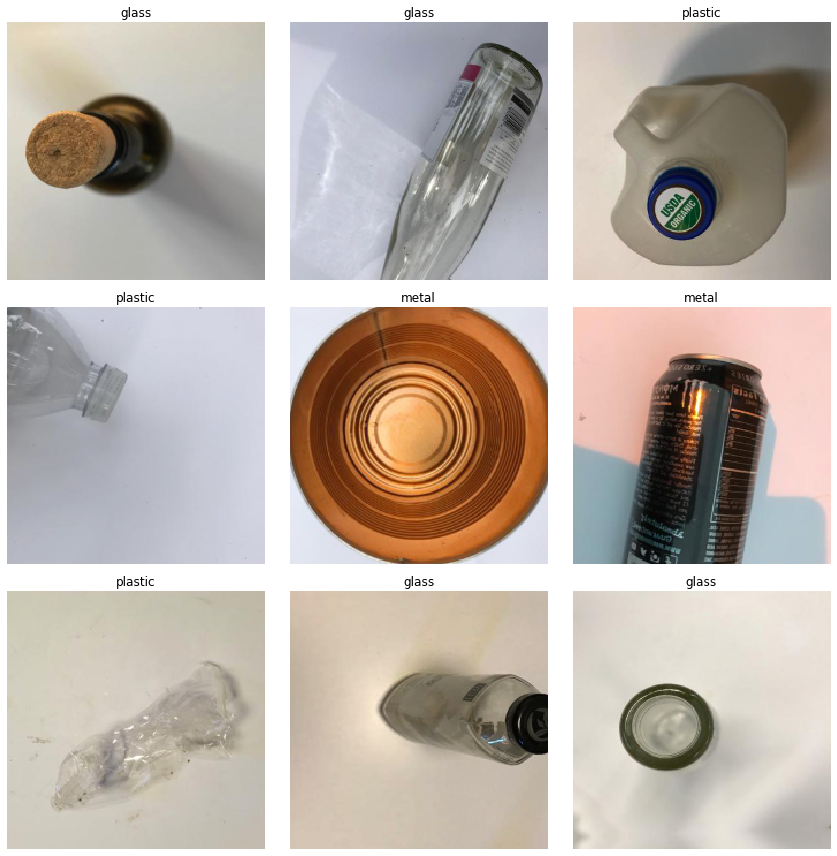

In [10]:
data.show_batch(rows=3, figsize=(12,12))

In [11]:
# number of classes, train set, validation set
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], 6, 4044, 1010)

# Train Model

In [12]:
# using resnet34
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [13]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.297782,0.555752,0.185149,00:26
1,0.757056,0.343797,0.119802,00:21
2,0.527919,0.260703,0.090099,00:21
3,0.398387,0.217462,0.084158,00:21
4,0.321695,0.183535,0.067327,00:21
5,0.246070,0.143202,0.048515,00:21
6,0.204769,0.125419,0.048515,00:21
7,0.168184,0.102184,0.031683,00:21
8,0.141454,0.101029,0.031683,00:21
9,0.140823,0.102872,0.029703,00:21


In [14]:
learn.save('waste-kaggle-stage-1')

In [15]:
learn.unfreeze()

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


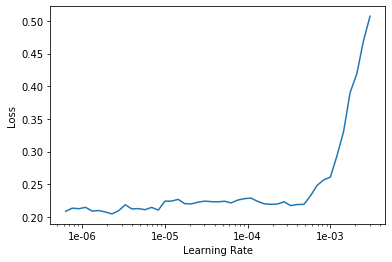

In [19]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(2,max_lr=1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.156638,0.180310,0.049505,00:27
1,0.125614,0.091679,0.027723,00:28


In [18]:
learn.save('waste-kaggle-stage-2')

# Interpretation

In [19]:
learn.load('waste-kaggle-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (4044 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
paper,paper,paper,paper,paper
Path: data/Kaggle Garbage Data;

Valid: LabelList (1010 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
metal,glass,cardboard,metal,cardboard
Path: data/Kaggle Garbage Data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, moment

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

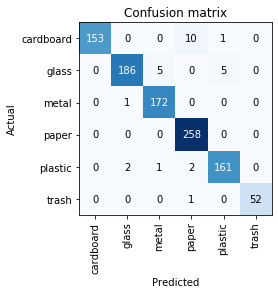

In [21]:
interp.plot_confusion_matrix()

# Cleaning Up

In [22]:
from fastai.widgets import *

In [23]:
# Create dataset without the split to clean the entire set of images. 
db = (ImageList.from_folder(path)
     .split_none()
     .label_from_folder()
     .transform(get_transforms(), size=224)
     .databunch()
     )

In [24]:
# Create new learner to use the new databunch
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('waste-kaggle-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (5054 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
paper,paper,paper,paper,paper
Path: data/Kaggle Garbage Data;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/Kaggle Garbage Data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1,

In [25]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [26]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [27]:
file = 'waste-kaggle-cleaned.csv'

In [28]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

In [29]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [30]:
learn = cnn_learner(data, models.resnet34, metrics = error_rate)

In [31]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.349080,0.592557,0.212871,00:21
1,0.761927,0.343516,0.131683,00:21
2,0.530715,0.246155,0.086139,00:21
3,0.387330,0.199140,0.070297,00:21
4,0.315147,0.158988,0.053465,00:21
5,0.244936,0.129612,0.044554,00:21
6,0.205551,0.116478,0.038614,00:21
7,0.177413,0.107164,0.032673,00:21
8,0.147193,0.107913,0.036634,00:22
9,0.130504,0.099575,0.036634,00:22


not much improvement after cleaning up some images - still @ ~3% error rate

Re-Training with 30% validation set

In [32]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.3,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [33]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [34]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.384986,0.601803,0.211741,00:21
1,0.826602,0.350303,0.122032,00:20
2,0.574296,0.258437,0.086412,00:20
3,0.436169,0.226486,0.075858,00:20
4,0.342369,0.173881,0.056728,00:21
5,0.257921,0.153910,0.050792,00:21
6,0.213258,0.139707,0.046174,00:20
7,0.184313,0.121611,0.043536,00:20
8,0.153369,0.113607,0.041557,00:21
9,0.138291,0.112495,0.036280,00:20


Same as 20% sample - ~3% error rate

In [36]:
learn.save('waste-30%val-stage-1')

In [37]:
learn.export()


# Open CV

In [38]:
learn.load('waste-kaggle-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (3538 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
paper,paper,paper,paper,paper
Path: data/Kaggle Garbage Data;

Valid: LabelList (1516 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
metal,glass,cardboard,metal,cardboard
Path: data/Kaggle Garbage Data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, moment

In [ ]:
import cv2
cap = cv2.VideoCapture(0)

while(True):
    ret, frame = cap.read()   #capture each frame
    cv2.imshow('FRAME',frame)
    
    #For capturing frame and saving it as an image at given folder:
    #if cv2.waitKey(1) == ord('n'):
    cv2.imwrite('test1.jpg',frame)
    img = open_image(pathlib.PosixPath('test1.jpg'))
        
    print(learn.predict(img))

    # Prediction of Waste Type
    label,index, pred = learn.predict(img)
    cv2.putText(frame, "Waste Tye = "+ str(label), (380, 25),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 215), 2)
    cv2.putText(frame, "Prob = {0:.4f}".format(torch.max(pred).item()), (380, 50),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
    cv2.imshow("FRAME",frame)
    print("Current Waste Type =\n",torch.max(pred).item())
    print("\t\t "+str(label)+"\t\t")

    #For quitting the given session: ord is used to obtain unicode of the given string.
    #cv2.waitKey returns the unicode of the key which is pressed
    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()